In [1]:
import numpy as np
import random
np.random.seed(432)
random.seed(123)
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

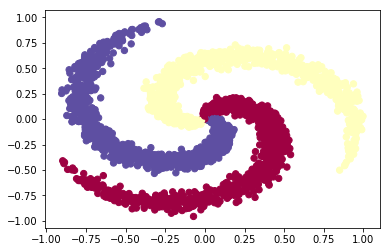

In [2]:
# generate data
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
X, y = shuffle(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [3]:
def softmax(x):
    """
    compute softmax on the input vector or input matrix (rowwise)
    """
    num = np.exp(x)
    return num/np.sum(num, axis=1, keepdims=True)

def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.mean(x, axis=1, keepdims=True)
    exps = np.exp(shiftx)
    return exps / np.sum(exps, axis=1, keepdims=True)


def softmax_grad(softmax_output):
    """
    requires: softmax output i.e ypred of one example
    returns: dypred/do2 , where o2 = W2^T * z1 + b, where z1 = sigmoid(o1)
    """
    return np.diag(softmax_output) - np.outer(softmax_output, softmax_output)

def categorical_crossentropy(ytrue, ypred):
    return -np.sum(ytrue * np.log10(ypred), axis=1, keepdims=True)

def crossentropy_grad(ytrue, ypred):
    """
    returns dL/dypred
    """
    losses_grad = - ytrue/ypred
    losses_grad.shape = (losses_grad.shape[0], 1, K)
    return losses_grad

def sigmoid(x):
    return 1/(1 + np.exp(-x))
#     return 1/(1 + np.exp(np.clip(-x, 3, -3)))

def sigmoid_grad(x):
    """
    requires: vector output of sigmoid layer
    returns: dz1/do1
    """
    return np.diag(x * (1-x))

def weights2_grad(x):
    """
    requires: output vector from hidden layer
    returns: do2/dW2 which is the jacobian
    [z11, z12, ..., z1H,  0,  0, ...,  0, ... ,  0,  0, ... , 0;
    0,  0, ...,  0, z11, z12, ..., z1H, ... ,  0,  0, ... , 0;
    ...
    0,  0, ...,  0,  0,  0, ...,  0, ... , z11, z12, ..., z1H;
    ] which is of dimension K * HK, where H is the number of hidden units
    """
    wgrad = np.zeros((K, H*K))
    for i in range(K):
        wgrad[i, i*H : (i+1)*H] = x
    return wgrad

def bias2_grad(K):
    """
    returns do2/db2
    """
    return np.eye(K)

def weights1_grad(x):
    """
    requires: one input example
    returns: do1/dW1 which is the jacobian
    [x1, x2, ..., XD,  0,  0, ...,  0, ... ,  0,  0, ... , 0;
    0,  0, ...,  0, x1, x2, ..., xD, ... ,  0,  0, ... , 0;
    ...
    0,  0, ...,  0,  0,  0, ...,  0, ... , x1, x2, ..., xD;
    ] which is of dimension H * DH
    """
    wgrad = np.zeros((H, D*H))
    for i in range(H):
        wgrad[i, i*D : (i+1)*D] = x
    return wgrad

def bias1_grad(H):
    """
    returns do1/db1
    """
    return np.eye(H)

In [4]:
def plot_decision_boundary(X, y, W1, b1, W2, b2):
    # plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

In [5]:
def fit(X, y, eta, reg, W1, b1, W2, b2, loss_history, batch_size=16):
    batches = len(X)/batch_size + 1
    y_one_hot = np.eye(K)[y]
    for i in xrange(batches):
        # take care of last batch
        if i * batch_size > len(X):
            xbatch = X[i * batch_size:, :]
            ybatch = y_one_hot[i * batch_size:]
        else:
            xbatch = X[i * batch_size: (i+1) * batch_size, :]
            ybatch = y_one_hot[i * batch_size: (i+1) * batch_size]

        # forward pass
        o1 = np.matmul(xbatch, W1) + b1
        z1 = sigmoid(o1)
        o2 = np.matmul(z1, W2) + b2
        ypred = stablesoftmax(o2)

        # backprop
        losses = categorical_crossentropy(ybatch, ypred)
        batch_loss = np.mean(losses)
        loss_history.append(batch_loss)

        loss_grads = crossentropy_grad(ybatch, ypred)
        sftmx_grads = np.asarray(map(softmax_grad, ypred))
        W2_grads = np.asarray(map(weights2_grad, z1))
        b2_grads = np.asarray(map(bias2_grad, [K]*len(ybatch)))
        o2_z1_grad = W2.T
        sigmoid_grads = np.asarray(map(sigmoid_grad, z1))
        W1_grads = np.asarray(map(weights1_grad, xbatch))
        b1_grads = np.asarray(map(bias1_grad, [H]*len(ybatch)))        
        
        def matmul(*mat):
            x = 1
            for m in mat:
                x = np.dot(x, m)
            return x
            
        ls_grads = map(matmul, loss_grads, sftmx_grads)
        o2_sigmoid_grads = map(matmul, [o2_z1_grad]*len(ybatch), sigmoid_grads)
        ls_o2_sigmoid_grads = map(matmul, ls_grads, o2_sigmoid_grads)
        
        # dL/dW2
        lW2_g = np.mean(map(matmul, ls_grads, W2_grads), axis=0)
        # dL/db2
        lb2_g = np.mean(map(matmul, ls_grads, b2_grads), axis=0)
        # dL/dW1
        lW1_g = np.mean(map(matmul, ls_o2_sigmoid_grads, W1_grads), axis=0)
        # dL/db1
        lb1_g = np.mean(map(matmul, ls_o2_sigmoid_grads , b1_grads), axis=0)
        
        # update
        W2 = W2 - eta * (lW2_g.reshape((H, K)) )#+ reg * W2)
        b2 = b2 - eta * lb2_g
        W1 = W1 - eta * (lW1_g.reshape((D, H)) )#+ reg * W1)
        b1 = b1 - eta * lb1_g
        return W1, b1, W2, b2

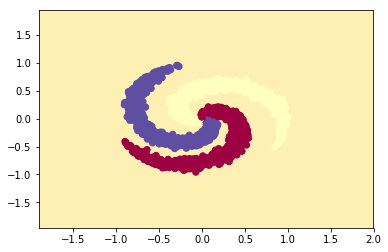

epoch  1
training accuracy: 0.33


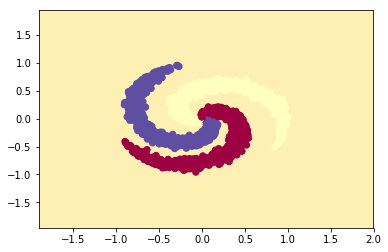

epoch  201
training accuracy: 0.56


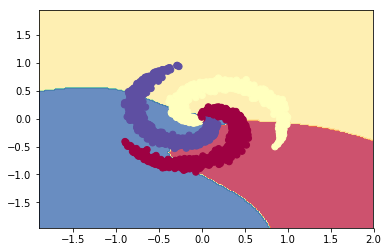

epoch  401
training accuracy: 0.63


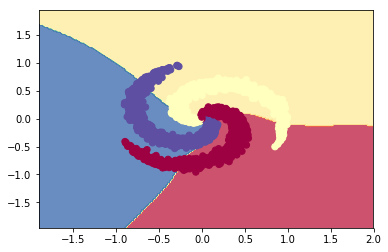

epoch  601
training accuracy: 0.78


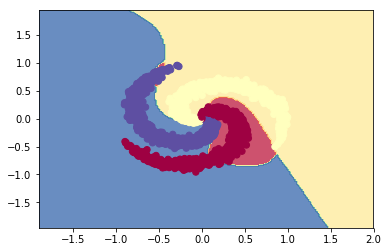

epoch  801
training accuracy: 0.84


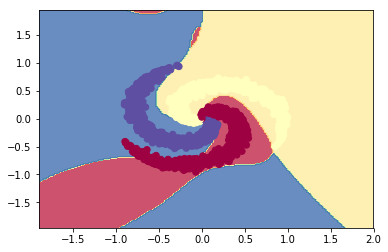

epoch  1001
training accuracy: 0.87


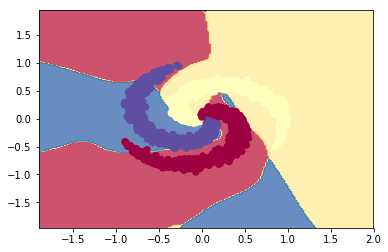

epoch  1201
training accuracy: 0.91


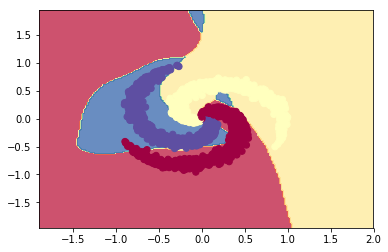

epoch  1401
training accuracy: 0.95


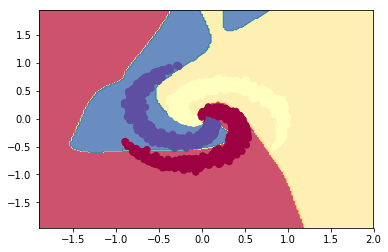

epoch  1601
training accuracy: 0.96


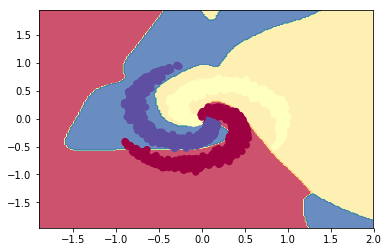

epoch  1801
training accuracy: 0.96


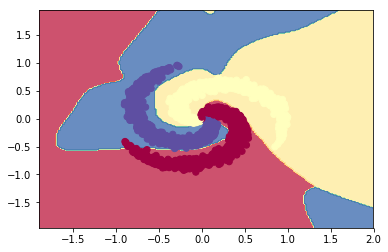

epoch  2001
training accuracy: 0.96


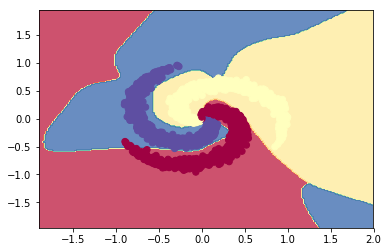

epoch  2201
training accuracy: 0.96


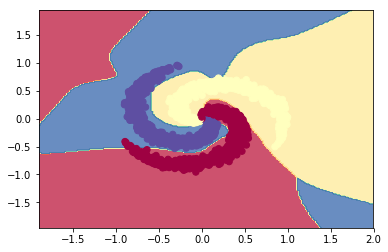

epoch  2401
training accuracy: 0.96


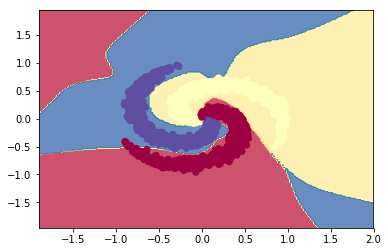

epoch  2601
training accuracy: 0.96


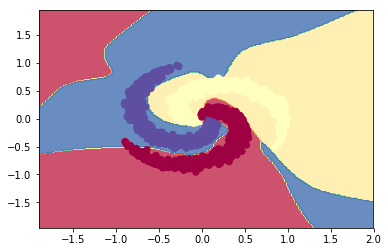

epoch  2801
training accuracy: 0.96


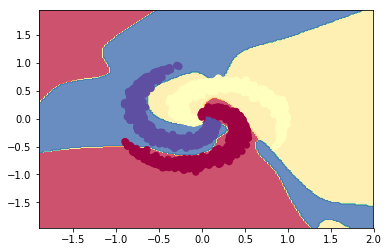

epoch  3001
training accuracy: 0.96


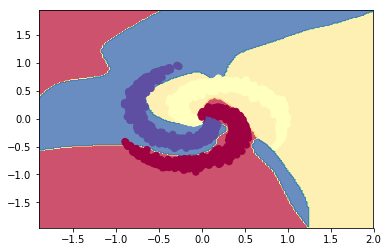

epoch  3201
training accuracy: 0.96


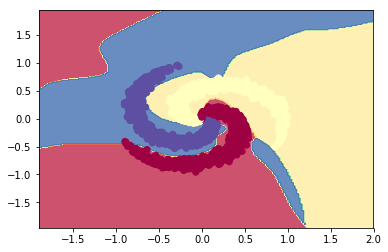

epoch  3401
training accuracy: 0.96


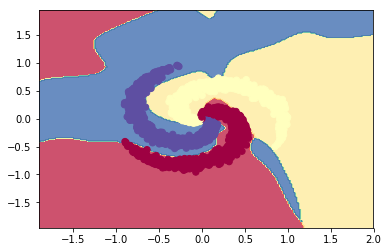

epoch  3601
training accuracy: 0.96


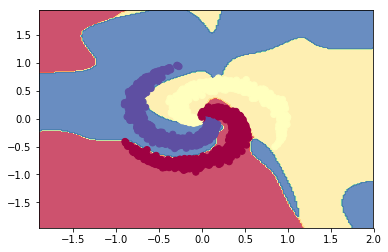

epoch  3801
training accuracy: 0.96


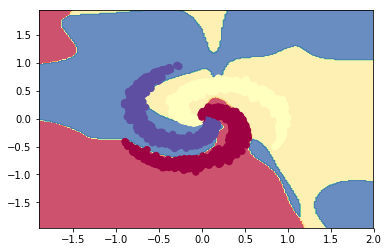

In [6]:
np.random.seed(42)
random.seed(123)
loss_history = []
H = 20 # num hidden units
W2 = np.random.randn(H, K)
b2 = np.random.random((1, K))
W1 = np.random.randn(D, H)
b1 = np.random.random((1, H))
plot_decision_boundary(X, y, W1, b1, W2, b2)
eta = 1 # learning rate
reg = 1e-3 # regularization strength

for epoch in range(4000):
    scores = np.dot(sigmoid(np.dot(X, W1) + b1), W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    training_acc = np.mean(predicted_class == y)
    
    if epoch % 200 == 0:
        print "epoch ", epoch + 1
        print 'training accuracy: %.2f' % (training_acc)
        plot_decision_boundary(X, y, W1, b1, W2, b2)
    W1, b1, W2, b2 = fit(X, y, eta, reg, W1, b1, W2, b2, loss_history, batch_size=300)

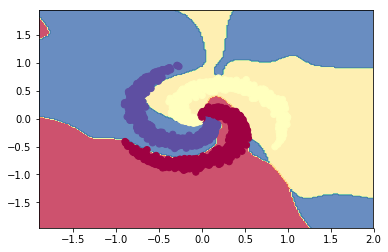

In [7]:
plot_decision_boundary(X, y, W1, b1, W2, b2)

[0.062670481480859033, 0.062672962053706011, 0.062675336382755867, 0.062677603882933475, 0.062679763966965604, 0.062681816045304053, 0.062683759526046171, 0.062685593814852142, 0.062687318314860005, 0.062688932426596913]


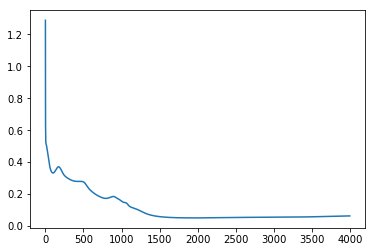

In [8]:
plt.plot(loss_history)
print loss_history[-10:]
plt.show()

In [9]:
# evaluate training set accuracy
scores = np.dot(sigmoid(np.dot(X, W1) + b1), W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.96
